In [1]:
import copy
import os
import time
import operator
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
Alldata = None

In [3]:
data_dir = 'dataset'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def get_dataset(data_dir):
        file_list = sorted(os.listdir(data_dir))
        dataset_file = []
        for file in file_list:
            if file.find("dataset") != -1:
                dataset_file.append(os.path.join(data_dir, file))
        return dataset_file

In [5]:
 def probability_distribution(data, name, bins=50):
        figure, (ax0, ax1) = plt.subplots(2, 1)
        ax0.hist(data, bins, facecolor='blue', edgecolor='black', alpha=0.75, weights=np.ones_like(data) / len(data))
        ax0.set_title(name + ' p_distributation')
        ax1.hist(data, bins, density=True, facecolor='yellowgreen', edgecolor='black', alpha=0.75, cumulative=True)
        ax1.set_title(name + ' sum_distribution')
        plt.show()
        figure.savefig(name + '.png', dpi=600, format='png')

In [6]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.activation = nn.PReLU()
        self.linear1 = nn.Sequential(nn.Linear(input_dim, 100), self.activation)
        self.linear2 = nn.Sequential(nn.Linear(100, 100), self.activation)
        self.linear3 = nn.Sequential(nn.Linear(100, 64), self.activation)
        self.linear4 = nn.Sequential(nn.Linear(64, 64), self.activation)
        self.linear5 = nn.Sequential(nn.Linear(64, 64), self.activation)
        self.linear6 = nn.Sequential(nn.Linear(64, 32), self.activation)
        self.linear7 = nn.Sequential(nn.Linear(32, 16), self.activation)
        self.linear8 = nn.Sequential(nn.Linear(16, 1), self.activation)
        self.model = nn.Sequential(self.linear1, self.linear2, self.linear3, self.linear4, self.linear5, self.linear6,
                                   self.linear7, self.linear8)

    def forward(self, x):
        out = self.model(x)
        return out

In [7]:
class ReDistanceTool():
    def __init__(self, graph_path, graph_name, graph_type):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.train_split = 0.8

        self.graph_path = graph_path
        self.graph_type = graph_type  # 0: unweighted 1: weighted
        self.graph_name = graph_name
        # use id to save
        self.label_to_id_map = dict()
        self.beacons_start = 0
        # how to concat
        self.src_set = list()  # const train pairs
        self.des_set = list()
        self.init_beacons_num = 50
        self.iter_beacons_num = 10
        self.max_beacons_num = 100
        self.max_paris = 20
        self.max_relative_error = 1e-2
        self.train_size = 1000
        self.beacons = set([])
        self.graph = None
        self.dis_data = None
        self.dis_value = None
        self.errors = {'max_error': [], 'mean_error': [], 'max_relative_error': [], 'mean_relative_error': []}
        np.random.seed(42)
        self.init_graph()
        self.label_to_id_map = {list(self.graph.nodes())[index]:index for index in range(self.graph.order())}
        global Alldata
        print(type(Alldata))
        time1 = time.time()
        self.distance_dict = dict(nx.all_pairs_shortest_path_length(self.graph)) if not Alldata else Alldata # iterator with dictionary keyed by target and shortest path length as the key value
        Alldata = copy.deepcopy(self.distance_dict)
        time2 = time.time()
        print("compute cost {:2f} s".format(time2 - time1))
        ## to see whether ordered insert
        #         test_num = 3
        #         i = 0
        #         for key, value in self.distance_dict.items():
        #             print(key)
        #             i += 1
        #             j= 0
        #             for key_s, value_s in value.items():
        #                 print(key_s)
        #                 j += 1
        #                 if j >= 3:
        #                     break
        #             if i >= 3:
        #                 break
        #         print((list)self.graph.nodes()[:2])
        ######################## the answer is no ##################

        time1 = time.time()
        self.distance_dict_numpy = self.prepare_distance_numpy()
        time2 = time.time()
        print("construct cost {:2f} s".format(time2 - time1))
        self.init_beacons()
        self.init_train_pairs()
        while(len(self.src_set) <= 100):
            self.init_beacons()
            self.init_train_pairs()

    def init_graph(self):
        if self.graph_type == 0:
            self.graph = nx.read_edgelist(self.graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)
        elif self.graph_type == 1:
            self.graph = nx.read_weighted_edgelist(self.graph_path, comments="#", delimiter=None, create_using=nx.Graph, nodetype= int)

    def init_beacons(self):
        self.beacons = None
        while self.beacons is None or len(self.beacons) < self.init_beacons_num:
            beacon = random.choice(list(range(self.graph.order())))
            if np.where(self.distance_dict_numpy[beacon,:] != np.inf)[0].size > 2*self.train_size  and np.where(self.distance_dict_numpy[:, beacon] != np.inf)[0].size > 2*self.train_size:
                self.beacons = set([beacon]) if self.beacons is None else self.beacons | set([beacon])

    def init_train_pairs(self):
        self.src_set.clear()
        self.des_set.clear()
        nodes_id = list(range(self.graph.order()))
#         for i in range(self.train_size):
#             src_node_id = random.choice(node_id)
#             des_node_id = random.choice(node_id)
#             self.src_set.append(random.choice(node_id))
#             self.des_set.append(random.choice(node_id))
#         temp_src_set = [random.choice(nodes_id) for _ in range(self.train_size)]
#         temp_des_set = [random.choice(nodes_id) for _ in range(self.train_size)]
        for i in range(self.train_size):
            src = random.choice(nodes_id)
            des = random.choice(nodes_id)
            if np.max(self.distance_dict_numpy[src, list(self.beacons)]) != np.inf and np.max(self.distance_dict_numpy[list(self.beacons), des]) != np.inf and self.distance_dict_numpy[src, des] != np.inf:
                self.src_set.append(src)
                self.des_set.append(des)
#         if self.train_size <= self.graph.order():
#             id_src = np.random.permutation(self.graph.order())[:self.train_size]
#             id_des = np.random.permutation(self.graph.order())[:self.train_size]
#         for id in range(self.train_size):
#             src_id = id_src[id]
#             des_id = id_des[id]
#             if src_id != des_id:
#                 self.src_set.append(src_id)
#                 self.des_set.append(des_id)
        print("get %d valid pairs" % len(self.src_set))

    def prepare_distance_numpy(self):
        # for node_src in range(self.graph.order()):
        #     for node_des in range(self.graph.order()):
        #         self.distance_dict_numpy[node_src, node_des] = self.distance_dict[list(self.graph.nodes())[node_src]][list(self.graph.nodes())[node_des]]
        ## The loop costs much time, refer to https://stackoverflow.com/questions/54021117/convert-dictionary-to-numpy-array we can change it
        # if the dictionary is inserted with the same order of graph.nodes() which means that array[0,1] represent the distance from g.nodes[0] to g.nodes[1]
        # ans = np.array([list(item.values()) for item in self.distance_dict.values()])
        # if the above dictionary are not satisfied, we can use the operator itemgetter
        distance_dict_temp = {node :{node: np.inf for node in self.graph.nodes()} for node in self.graph.nodes()}
        distance_dict = {node : (distance_dict_temp[node].update(self.distance_dict[node]),distance_dict_temp[node])[1] for node in self.graph.nodes()}
        getter = operator.itemgetter(*list(self.graph.nodes()))
        ans = np.array([getter(item) for item in getter(distance_dict)])
        return ans

    def prepare_train_set(self):
        dis_src = self.distance_dict_numpy[np.ix_(self.src_set, list(self.beacons))]
        dis_des = self.distance_dict_numpy[np.ix_(list(self.beacons),self.des_set)].T
        ## plus L and U
        L = np.max(np.abs(dis_src - dis_des), axis = 1).reshape(len(self.src_set),1)
        U = np.min(np.abs(dis_src - dis_des), axis = 1).reshape(len(self.des_set),1)
        dis_data = np.concatenate((dis_src, dis_des, L, U), axis=1)
        self.dis_data = dis_data
        self.dis_value = self.distance_dict_numpy[self.src_set, self.des_set]

    def obtain_beacons(self, worst_paris, beacons_num, sampler = 0):
        scores = dict.fromkeys(self.graph, 0.0) # beacons score
        samplers = [0, 1, 2]
        if sampler not in samplers:
            raise Exception("Not supported sampler")
        hyedges = []
        nodes = list(self.graph.nodes())
        for (src_id, des_id) in worst_paris:
            src = nodes[src_id]
            des = nodes[des_id]
            try:
                paths = nx.all_shortest_paths(self.graph, source=src, target=des)
                paths = [list(path) for path in paths]
            except nx.NetworkXNoPath:
                continue
            if sampler == 0:  ## hyedge
                hyedge = list(paths[random.randint(0, len(paths) - 1)])
                hyedge.remove(src)
                hyedge.remove(des)
                for node in hyedge:
                    scores[node] += 1
            elif sampler == 1: ## original hyedge
                hyedge = list(paths[random.randint(0, len(paths) - 1)])
                hyedge.remove(src)
                hyedge.remove(des)
                if len(hyedge) > 0:
                    hyedges.append(hyedge)
            elif sampler == 2:  ## yalg
                hyedge = []
                num_path = 0
                for path in paths:
                    num_path += 1
                    path.remove(src)
                    path.remove(des)
                    hyedge += path
                for node in hyedge:
                    scores[node] += 1 / num_path

        if sampler == 1:
            while len(hyedges) > 1:
                count = {}
                max_degree = 0
                max_node = 0
                for hyedge in hyedges:
                    for node in hyedge:
                        value = count.get(node, 0)
                        count[node] = value + 1
                for node, degree in count.items():
                    if degree >= max_degree:
                        max_degree = degree
                        max_node = node
                scores[max_node] = len(hyedges)
                # remove
                hyedges = [hyedge for hyedge in hyedges if max_node not in hyedge]
                # for hyedge in hyedges:
                #     for node in hyedge:
                #         bc_estimation[node]  += step
        score_array = np.array([scores[nodes[id]] for id in range(self.graph.order())])
        order1 = np.argsort(-score_array)
        return order1.tolist()[:beacons_num]

    def add_beacons(self, target_pairs):
        ## add the most often occured nodes
        new_beacons_id = set(self.obtain_beacons(target_pairs, beacons_num = self.iter_beacons_num, sampler = 0))
        orign_num = len(self.beacons)
#         for beacon in new_beacons_id:
#             if np.max(self.distance_dict_numpy[self.src_set, beacon]) != np.inf and np.max(self.distance_dict_numpy[self.des_set, beacon]) != np.inf:
#                 self.beacons.add(beacon)
        new_beacons = set([beacon for beacon in new_beacons_id if np.max(self.distance_dict_numpy[self.src_set, beacon]) != np.inf and np.max(self.distance_dict_numpy[self.des_set, beacon]) != np.inf])
        self.beacons |= new_beacons
        now_num = len(self.beacons)
        print("add {} new beacons".format(now_num - orign_num))
    
    def probability_distribution(self, data, folder, name, bins=50):
        figure, (ax0, ax1) = plt.subplots(2, 1)
        ax0.hist(data, bins, facecolor='blue', edgecolor='black', alpha=0.75, weights=np.ones_like(data) / len(data))
        ax0.set_title(name + ' p_distributation')
        ax1.hist(data, bins, density=True, facecolor='yellowgreen', edgecolor='black', alpha=0.75, cumulative=True)
        ax1.set_title(name + ' sum_distribution')
        plt.show()
        figure.savefig(folder +"/" +name + 'with_LU.png', dpi=600, format='png')
        
        
    def draw(self, history, estimation, y_test):
        errors = {'max_error': [], 'mean_error': [], 'max_relative_error': [], 'mean_relative_error': []}
        name = self.graph_name+ "_"+ str(len(self.beacons))
        figure = plt.figure(name)
        plt.title("{}: loss".format(name))
        train_pl = plt.plot(history['train'][5:], label='train_loss')
        val_pl = plt.plot(history['val'][5:], label='val_loss')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.legend()
        # write_result(bt, G_info_list[i], end - start)
        figure.savefig("result_loss/{} with_LU.png".format(name), dpi=600, format='png')
        plt.show()
#         torch.save({
#             'model_weights': net.state_dict(),
#             'history': history
#         }, './models/{}_model.pkl'.format(name))
        estimation = np.round(np.squeeze(estimation))
        error_abs = np.abs(estimation - y_test)
        error_relative = np.abs(estimation - y_test) / y_test
        mask = np.isfinite(error_relative)
        error_relative = error_relative[mask]

        self.probability_distribution(error_relative, "result_data", name + '_relative_error', 100)
        max_error = np.max(error_abs)
        mean_error = np.mean(error_abs)
        max_relative_error = np.max(error_relative)
        mean_relative_error = np.mean(error_relative)
        errors['max_error'].append(max_error)
        errors['mean_error'].append(mean_error)
        errors['max_relative_error'].append(max_relative_error)
        errors['mean_relative_error'].append(mean_relative_error)
        estimation = estimation.tolist()
        result_file = "result_data" + name + "_estimation.csv"
        with open(result_file, 'w+') as f:
            for idx, dist in enumerate(estimation):
                f.writelines(str(dist) + '\t' + str(y_test[idx]) + '\n')

    def train(self, num_epochs=500, batch_size = 64, verbose=True):
        loss_beacons = {"best_train":[], "final_train":[], "final_val":[]}
        beacons_num = []
        epoch_max_loss = 1e-2
        epoch_max_diff_loss = 1e-4

        criterion = nn.MSELoss()

        while(len(self.beacons) <= self.max_beacons_num):
            # prepare data loader
            self.prepare_train_set()
            model =  LinearRegression(self.dis_data.shape[1])
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            model.to(self.device)
            print('x dataset shape: {}, y shape: {}'.format(self.dis_data.shape, self.dis_value.shape))
            train_num = (int)(len(self.dis_data)*self.train_split)
            train_data = self.dis_data[:train_num]
            train_value = self.dis_value[:train_num]
            val_data = self.dis_data[train_num:]
            val_value = self.dis_value[train_num:]
            train_inputs = torch.from_numpy(train_data).type(torch.float)
            train_targets = torch.from_numpy(train_value).type(torch.float)
            val_inputs = torch.from_numpy(val_data).type(torch.float)
            val_targets = torch.from_numpy(val_value).type(torch.float)
            train_dataset = TensorDataset(train_inputs, train_targets)
            dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
            history = {'train': [], 'val': []}
            since = time.time()
            best_train_loss = np.inf
            best_val_loss = np.inf
            # best_model_wts = copy.deepcopy(model.state_dict())
            epoch_losses = []
            for epoch in range(num_epochs):
#                 print('Epoch {}/{}'.format(epoch + 1, num_epochs))
#                 print('-' * 10)

                # Each epoch has a training and validation phase
                model.train()
                running_loss = 0.0
                num = 0
                # Iterate over data.
                for x, y in dataloader:
                    num += x.size(0)
                    x = x.to(self.device)
                    y = y.to(self.device)
                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        estimation = model(x)
                        estimation = estimation.squeeze()
                        loss = criterion(estimation, y)
                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                    # statistics
                    running_loss += loss.item() * x.size(0)
                ## val
                model.eval()
                val_inputs = val_inputs.to(self.device)
                pred_v = model(val_inputs)
                pred_v = pred_v.squeeze()
                pred_s_v = pred_v.cpu().detach().numpy()
                val_targets_s = val_targets.numpy()
                final_val_loss = np.mean(np.power(pred_s_v - val_targets_s, 2))
                history["val"].append(final_val_loss)
                epoch_loss = running_loss / num
                history["train"].append(epoch_loss)
#                 print('train Loss: {:.4f}'.format(epoch_loss))
                if epoch_loss <= best_train_loss:
                    best_train_loss = epoch_loss
                epoch_losses.append(epoch_loss)
                # early stopping
                # if len(epoch_losses) >= 4:
                #     np_losses = np.array(epoch_losses[-4:0])
                #     if np.max(np_losses) < epoch_max_loss and np.max(np.diff(np_losses)) < epoch_max_diff_loss:
                #         print("early stopping at epoch {}".format(epoch))
                #         break

                # deep copy the model

#                 print()

            model.eval()
            train_inputs = train_inputs.to(self.device)
            pred = model(train_inputs)
            pred = pred.squeeze()
            pred_s = pred.cpu().detach().numpy()
            train_targets_s = train_targets.numpy()
            final_train_loss = np.mean(np.power(pred_s - train_targets_s, 2))
            max_pair_s = np.argsort(-(np.power(pred_s - train_targets_s, 2)))[:self.max_paris].tolist()
            
            node_color = ['r'] * self.graph.order()
            for pair in max_pair_s:
                src = self.src_set[pair]
                des = self.des_set[pair]
                print("src:{} des:{}, true:{} est:{}".format( self.src_set[pair],self.des_set[pair],train_targets_s[pair],pred_s[pair]))
                node_color[src] = 'b'
                node_color[des] = 'b'
            nx.draw_networkx_nodes(self.graph, node_size=5, node_shape="o",edge_size=1, with_labels=True, pos=nx.spring_layout(self.graph), node_color= node_color)
            plt.show()
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            val_inputs = val_inputs.to(self.device)
            pred_v = model(val_inputs)
            pred_v = pred_v.squeeze()
            pred_s_v = pred_v.cpu().detach().numpy()
            val_targets_s = val_targets.numpy()
            final_val_loss = np.mean(np.power(pred_s_v - val_targets_s, 2))
            self.draw(history, pred_s_v, val_targets_s)
            print('Best train loss: {:4f} for # {} beacons'.format(best_train_loss, len(self.beacons)))
            print('Final train loss: {:4f} for # {} beacons'.format(final_train_loss, len(self.beacons)))
            print('Final val loss: {:4f} for # {} beacons'.format(final_val_loss, len(self.beacons)))
            loss_beacons["best_train"].append(best_train_loss)
            loss_beacons["final_train"].append(final_train_loss)
            loss_beacons["final_val"].append(final_val_loss)
            beacons_num.append(len(self.beacons))
            start = time.time()
            new_src = [self.src_set[index] for index in max_pair_s]
            new_des = [self.des_set[index] for index in max_pair_s]
            self.add_beacons(zip(new_src, new_des))
            print("add beacons cost %.2f s" % (time.time() - start))
            # load best model weights
            # model.load_state_dict(best_model_wts)
            # return model, history
        figure = plt.figure(self.graph_name)
        plt.title("{}: loss vs beacons_num".format(self.graph_name))
        best_train_pl = plt.plot(beacons_num, loss_beacons['best_train'], label='best_train_loss')
        final_train_pl = plt.plot(beacons_num, loss_beacons['final_train'], label='final_train_loss')
        final_val_pl = plt.plot(beacons_num, loss_beacons['final_val'], label='final_val_loss')
        plt.xlabel('beacons num')
        plt.ylabel('loss')
        plt.legend()
        # write_result(bt, G_info_list[i], end - start)
        figure.savefig("result_loss_with_beacons/{}with_LU.png".format(self.graph_name), dpi=600, format='png')
        plt.show()

# Note: how to solve the nodes in the pair is not connected 

begin to train
<class 'NoneType'>
compute cost 210.776999 s
construct cost 3.367303 s
get 1000 valid pairs
prepare cost 214.55 s
x dataset shape: (1000, 102), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.9636014699935913
src:1208 des:700, true:1.0 est:1.8040584325790405
src:877 des:853, true:1.0 est:1.8040584325790405
src:2111 des:2551, true:1.0 est:1.6658021211624146
src:2836 des:2595, true:1.0 est:1.6375740766525269
src:3399 des:2954, true:1.0 est:1.5481841564178467
src:896 des:3882, true:3.0 est:3.5453250408172607
src:1188 des:1184, true:1.0 est:1.5333629846572876
src:669 des:1022, true:1.0 est:1.4961777925491333
src:3121 des:847, true:3.0 est:3.4824118614196777
src:3603 des:664, true:3.0 est:3.4569294452667236
src:1394 des:1253, true:1.0 est:1.4315872192382812
src:2832 des:2491, true:2.0 est:1.6068283319473267
src:2019 des:1975, true:2.0 est:1.607384443283081
src:913 des:1215, true:2.0 est:1.6218550205230713
src:1576 des:1778, true:3.0 est:2.650383949279785
src:1563 des:374, 

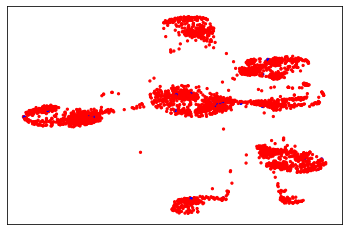

Training complete in 1m 47s


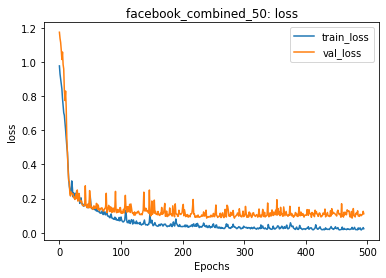

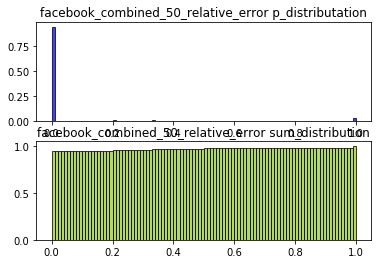

Best train loss: 0.016304 for # 50 beacons
Final train loss: 0.019296 for # 50 beacons
Final val loss: 0.111126 for # 50 beacons
add 10 new beacons
add beacons cost 0.51 s
x dataset shape: (1000, 122), y shape: (1000,)
src:3366 des:2986, true:1.0 est:2.0684356689453125
src:2836 des:2595, true:1.0 est:1.9865374565124512
src:2111 des:2551, true:1.0 est:1.967834711074829
src:1208 des:700, true:1.0 est:1.8707678318023682
src:877 des:853, true:1.0 est:1.717864990234375
src:1413 des:57, true:3.0 est:3.6838595867156982
src:3399 des:2954, true:1.0 est:1.6315081119537354
src:1188 des:1184, true:1.0 est:1.629098653793335
src:1436 des:1406, true:1.0 est:1.597078800201416
src:1394 des:1253, true:1.0 est:1.5375697612762451
src:896 des:3882, true:3.0 est:3.5171358585357666
src:669 des:1022, true:1.0 est:1.4481823444366455
src:1868 des:1976, true:2.0 est:2.4299819469451904
src:1840 des:1946, true:2.0 est:2.4299819469451904
src:3603 des:664, true:3.0 est:3.4271128177642822
src:381 des:3523, true:3.0 e

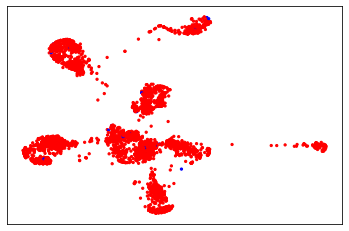

Training complete in 1m 43s


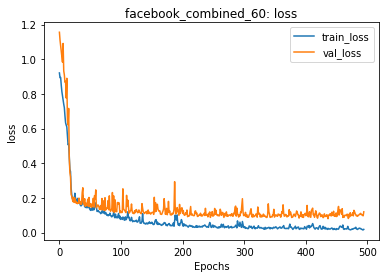

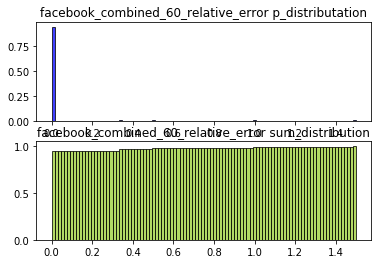

Best train loss: 0.015798 for # 60 beacons
Final train loss: 0.020624 for # 60 beacons
Final val loss: 0.120255 for # 60 beacons
add 6 new beacons
add beacons cost 0.64 s
x dataset shape: (1000, 134), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.9714610576629639
src:669 des:1022, true:1.0 est:1.7826943397521973
src:2111 des:2551, true:1.0 est:1.7683377265930176
src:2836 des:2595, true:1.0 est:1.737874984741211
src:1208 des:700, true:1.0 est:1.7189688682556152
src:913 des:1215, true:2.0 est:1.3908703327178955
src:1188 des:1184, true:1.0 est:1.5704822540283203
src:877 des:853, true:1.0 est:1.537813425064087
src:1394 des:1253, true:1.0 est:1.528451681137085
src:1478 des:411, true:3.0 est:2.554525375366211
src:3399 des:2954, true:1.0 est:1.4006154537200928
src:396 des:757, true:2.0 est:1.6319501399993896
src:1413 des:57, true:3.0 est:3.3432397842407227
src:496 des:774, true:2.0 est:1.6781940460205078
src:2019 des:1975, true:2.0 est:1.6903955936431885
src:1285 des:612, true:1.0 est:1.

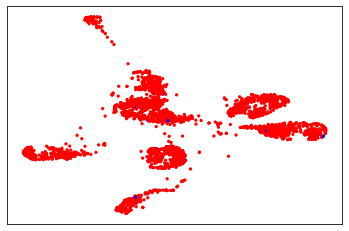

Training complete in 1m 50s


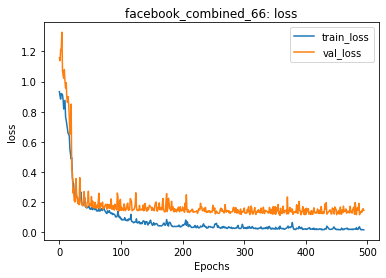

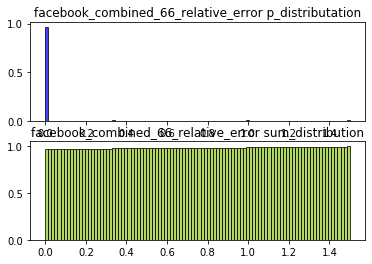

Best train loss: 0.015288 for # 66 beacons
Final train loss: 0.016373 for # 66 beacons
Final val loss: 0.145221 for # 66 beacons
add 7 new beacons
add beacons cost 0.51 s
x dataset shape: (1000, 148), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.8872406482696533
src:2836 des:2595, true:1.0 est:1.8794487714767456
src:2111 des:2551, true:1.0 est:1.7969468832015991
src:1208 des:700, true:1.0 est:1.7473987340927124
src:1188 des:1184, true:1.0 est:1.6814943552017212
src:3399 des:2954, true:1.0 est:1.536454439163208
src:877 des:853, true:1.0 est:1.529052495956421
src:1478 des:411, true:3.0 est:2.505723237991333
src:913 des:1215, true:2.0 est:1.5363084077835083
src:252 des:3317, true:4.0 est:3.5946948528289795
src:893 des:665, true:2.0 est:1.6227861642837524
src:1413 des:57, true:3.0 est:3.362276077270508
src:3565 des:1774, true:4.0 est:3.641641616821289
src:368 des:1486, true:3.0 est:2.6593921184539795
src:1992 des:1618, true:6.0 est:5.669835567474365
src:292 des:2975, true:4.0 est:3.6

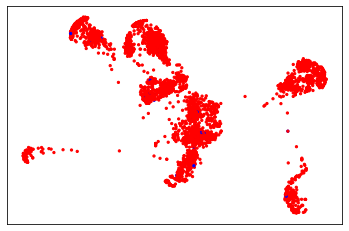

Training complete in 1m 42s


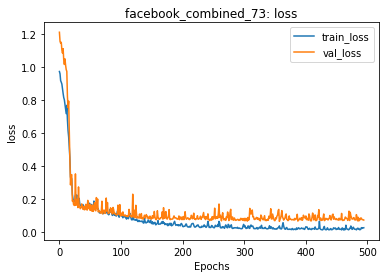

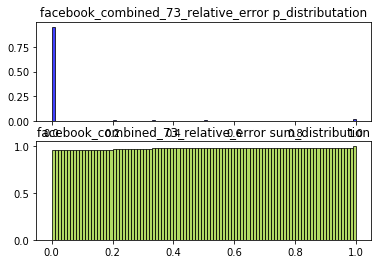

Best train loss: 0.014882 for # 73 beacons
Final train loss: 0.017765 for # 73 beacons
Final val loss: 0.074473 for # 73 beacons
add 3 new beacons
add beacons cost 0.60 s
x dataset shape: (1000, 154), y shape: (1000,)
src:2836 des:2595, true:1.0 est:2.0309083461761475
src:3366 des:2986, true:1.0 est:1.9743653535842896
src:2111 des:2551, true:1.0 est:1.9735912084579468
src:1208 des:700, true:1.0 est:1.9517449140548706
src:1188 des:1184, true:1.0 est:1.8636468648910522
src:877 des:853, true:1.0 est:1.7673046588897705
src:669 des:1022, true:1.0 est:1.741591215133667
src:1394 des:1253, true:1.0 est:1.638898491859436
src:3399 des:2954, true:1.0 est:1.596205234527588
src:3603 des:664, true:3.0 est:3.511411666870117
src:1285 des:612, true:1.0 est:1.4323558807373047
src:1131 des:835, true:1.0 est:1.407777190208435
src:1576 des:1778, true:3.0 est:2.623427391052246
src:2171 des:563, true:2.0 est:2.3680901527404785
src:171 des:1680, true:3.0 est:3.3649203777313232
src:913 des:1215, true:2.0 est:1

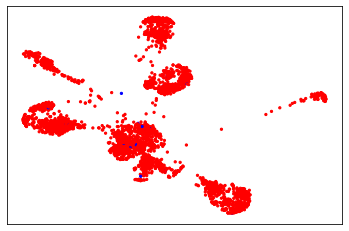

Training complete in 1m 51s


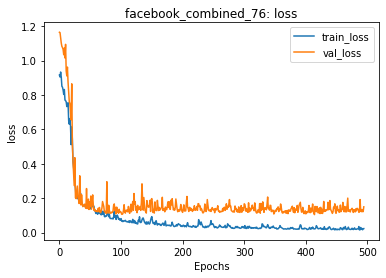

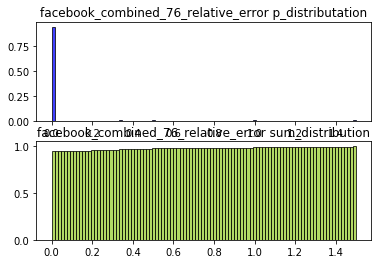

Best train loss: 0.015061 for # 76 beacons
Final train loss: 0.022693 for # 76 beacons
Final val loss: 0.149339 for # 76 beacons
add 2 new beacons
add beacons cost 0.55 s
x dataset shape: (1000, 158), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.9567567110061646
src:2836 des:2595, true:1.0 est:1.9498931169509888
src:1208 des:700, true:1.0 est:1.9453693628311157
src:2111 des:2551, true:1.0 est:1.8447123765945435
src:1188 des:1184, true:1.0 est:1.8391188383102417
src:877 des:853, true:1.0 est:1.7380468845367432
src:669 des:1022, true:1.0 est:1.5795025825500488
src:1394 des:1253, true:1.0 est:1.5521341562271118
src:290 des:1436, true:3.0 est:3.506187677383423
src:134 des:1415, true:3.0 est:3.506187677383423
src:3399 des:2954, true:1.0 est:1.4935048818588257
src:3603 des:664, true:3.0 est:3.4884603023529053
src:1413 des:57, true:3.0 est:3.481717348098755
src:1285 des:612, true:1.0 est:1.448403000831604
src:171 des:1680, true:3.0 est:3.428835868835449
src:2171 des:563, true:2.0 est:2.

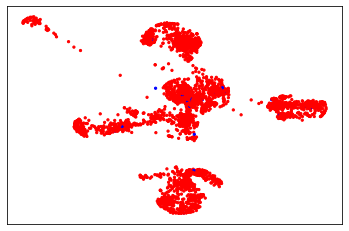

Training complete in 1m 48s


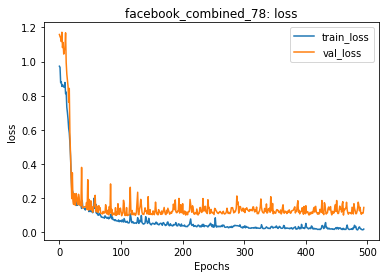

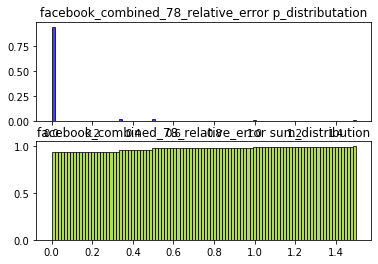

Best train loss: 0.013090 for # 78 beacons
Final train loss: 0.021479 for # 78 beacons
Final val loss: 0.144698 for # 78 beacons
add 2 new beacons
add beacons cost 0.58 s
x dataset shape: (1000, 162), y shape: (1000,)
src:3366 des:2986, true:1.0 est:2.044673442840576
src:2836 des:2595, true:1.0 est:1.9399244785308838
src:1208 des:700, true:1.0 est:1.9326698780059814
src:2111 des:2551, true:1.0 est:1.8901976346969604
src:1188 des:1184, true:1.0 est:1.889874815940857
src:877 des:853, true:1.0 est:1.7972619533538818
src:3399 des:2954, true:1.0 est:1.7422399520874023
src:3603 des:664, true:3.0 est:3.5763418674468994
src:1478 des:411, true:3.0 est:2.525378942489624
src:669 des:1022, true:1.0 est:1.474010705947876
src:1881 des:364, true:5.0 est:5.434591293334961
src:896 des:3882, true:3.0 est:3.431631565093994
src:1394 des:1253, true:1.0 est:1.401452660560608
src:1285 des:612, true:1.0 est:1.3990639448165894
src:1413 des:57, true:3.0 est:3.371752977371216
src:4026 des:1563, true:4.0 est:4.35

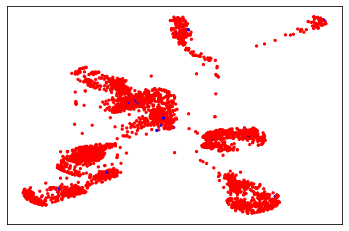

Training complete in 1m 51s


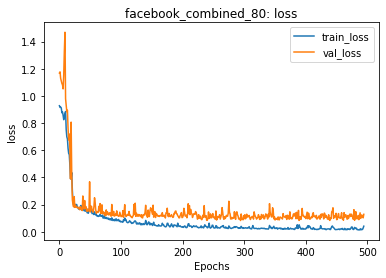

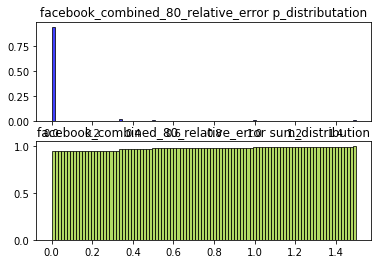

Best train loss: 0.012949 for # 80 beacons
Final train loss: 0.025803 for # 80 beacons
Final val loss: 0.127824 for # 80 beacons
add 2 new beacons
add beacons cost 0.50 s
x dataset shape: (1000, 166), y shape: (1000,)
src:2836 des:2595, true:1.0 est:1.8657935857772827
src:1208 des:700, true:1.0 est:1.8107026815414429
src:3366 des:2986, true:1.0 est:1.8022891283035278
src:2111 des:2551, true:1.0 est:1.8000413179397583
src:1188 des:1184, true:1.0 est:1.7465935945510864
src:877 des:853, true:1.0 est:1.6603714227676392
src:669 des:1022, true:1.0 est:1.570833683013916
src:1478 des:411, true:3.0 est:2.5231239795684814
src:3399 des:2954, true:1.0 est:1.419895052909851
src:1394 des:1253, true:1.0 est:1.416189193725586
src:913 des:1215, true:2.0 est:1.616806149482727
src:1413 des:57, true:3.0 est:3.3734943866729736
src:3454 des:3422, true:2.0 est:1.6460736989974976
src:3430 des:3014, true:2.0 est:1.6460736989974976
src:2019 des:1975, true:2.0 est:1.6525520086288452
src:355 des:3995, true:6.0 es

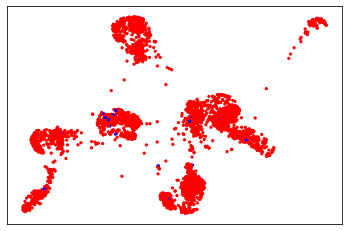

Training complete in 1m 48s


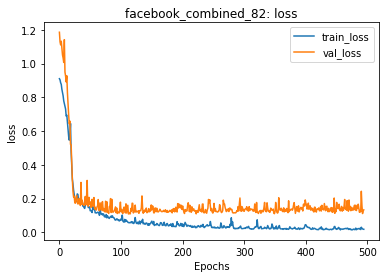

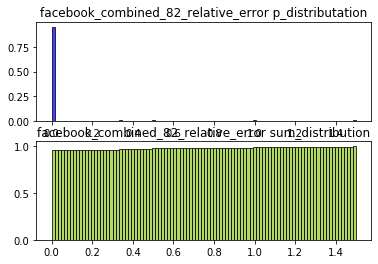

Best train loss: 0.014728 for # 82 beacons
Final train loss: 0.017915 for # 82 beacons
Final val loss: 0.133295 for # 82 beacons
add 4 new beacons
add beacons cost 0.58 s
x dataset shape: (1000, 174), y shape: (1000,)
src:2836 des:2595, true:1.0 est:1.9893193244934082
src:2111 des:2551, true:1.0 est:1.947026014328003
src:3366 des:2986, true:1.0 est:1.9383535385131836
src:1208 des:700, true:1.0 est:1.8314423561096191
src:1188 des:1184, true:1.0 est:1.6511926651000977
src:877 des:853, true:1.0 est:1.5977295637130737
src:913 des:1215, true:2.0 est:1.4352947473526
src:893 des:665, true:2.0 est:1.44099760055542
src:1478 des:411, true:3.0 est:2.474991798400879
src:669 des:1022, true:1.0 est:1.5173858404159546
src:1394 des:1253, true:1.0 est:1.4129735231399536
src:1131 des:835, true:1.0 est:1.394813895225525
src:3603 des:664, true:3.0 est:3.3340437412261963
src:3430 des:3014, true:2.0 est:1.6792819499969482
src:3454 des:3422, true:2.0 est:1.6792819499969482
src:1848 des:2910, true:4.0 est:4.2

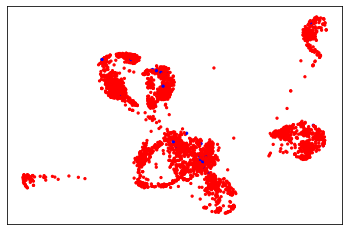

Training complete in 1m 47s


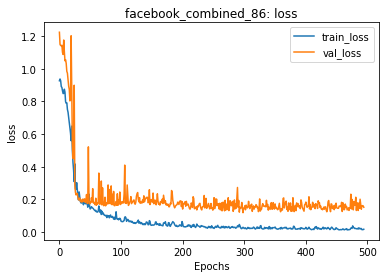

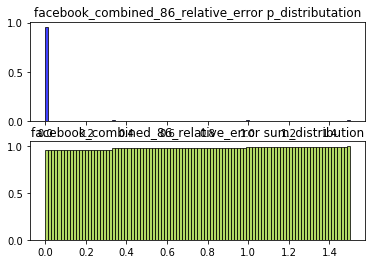

Best train loss: 0.013543 for # 86 beacons
Final train loss: 0.016413 for # 86 beacons
Final val loss: 0.152168 for # 86 beacons
add 3 new beacons
add beacons cost 0.51 s
x dataset shape: (1000, 180), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.9576256275177002
src:2836 des:2595, true:1.0 est:1.907191276550293
src:1208 des:700, true:1.0 est:1.9057800769805908
src:2111 des:2551, true:1.0 est:1.8830511569976807
src:1188 des:1184, true:1.0 est:1.8132580518722534
src:877 des:853, true:1.0 est:1.7819503545761108
src:1131 des:835, true:1.0 est:1.5239499807357788
src:669 des:1022, true:1.0 est:1.5165019035339355
src:3399 des:2954, true:1.0 est:1.5149695873260498
src:3603 des:664, true:3.0 est:3.4945335388183594
src:1394 des:1253, true:1.0 est:1.4693996906280518
src:1285 des:612, true:1.0 est:1.4033795595169067
src:1413 des:57, true:3.0 est:3.3752706050872803
src:896 des:3882, true:3.0 est:3.363878011703491
src:1881 des:364, true:5.0 est:5.349123954772949
src:913 des:1215, true:2.0 est:

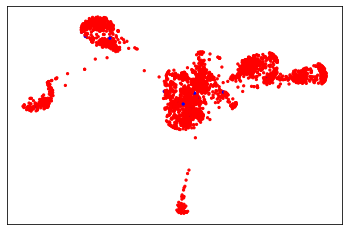

Training complete in 1m 49s


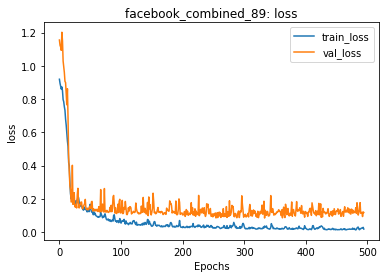

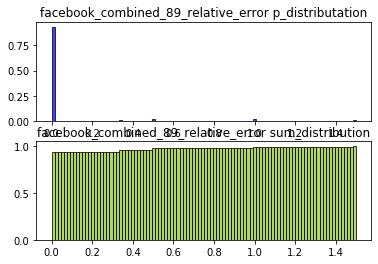

Best train loss: 0.013185 for # 89 beacons
Final train loss: 0.016619 for # 89 beacons
Final val loss: 0.117694 for # 89 beacons
add 2 new beacons
add beacons cost 0.58 s
x dataset shape: (1000, 184), y shape: (1000,)
src:2836 des:2595, true:1.0 est:2.0239086151123047
src:2111 des:2551, true:1.0 est:1.9837360382080078
src:3366 des:2986, true:1.0 est:1.976703405380249
src:1208 des:700, true:1.0 est:1.9643137454986572
src:1188 des:1184, true:1.0 est:1.845505952835083
src:877 des:853, true:1.0 est:1.7984321117401123
src:3399 des:2954, true:1.0 est:1.7403273582458496
src:669 des:1022, true:1.0 est:1.7103800773620605
src:1394 des:1253, true:1.0 est:1.6242560148239136
src:1131 des:835, true:1.0 est:1.5705474615097046
src:1868 des:1976, true:2.0 est:2.537729501724243
src:896 des:3882, true:3.0 est:3.5321316719055176
src:1840 des:1946, true:2.0 est:2.5292561054229736
src:2171 des:563, true:2.0 est:2.4890758991241455
src:3603 des:664, true:3.0 est:3.458184242248535
src:1881 des:364, true:5.0 es

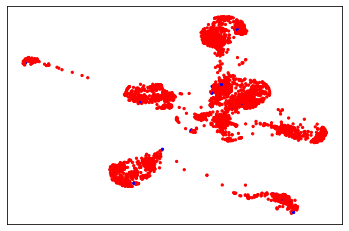

Training complete in 1m 48s


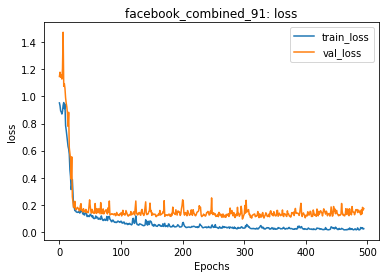

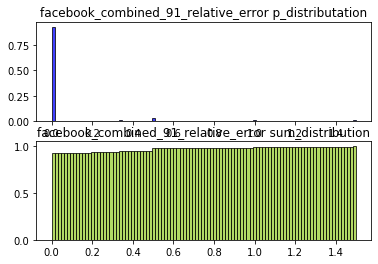

Best train loss: 0.013924 for # 91 beacons
Final train loss: 0.025260 for # 91 beacons
Final val loss: 0.171760 for # 91 beacons
add 2 new beacons
add beacons cost 0.50 s
x dataset shape: (1000, 188), y shape: (1000,)
src:2836 des:2595, true:1.0 est:1.9993813037872314
src:2111 des:2551, true:1.0 est:1.950740098953247
src:1208 des:700, true:1.0 est:1.920480489730835
src:1188 des:1184, true:1.0 est:1.8516850471496582
src:3366 des:2986, true:1.0 est:1.8413501977920532
src:669 des:1022, true:1.0 est:1.800274133682251
src:877 des:853, true:1.0 est:1.7981846332550049
src:1131 des:835, true:1.0 est:1.7522566318511963
src:1868 des:1976, true:2.0 est:2.7392687797546387
src:1840 des:1946, true:2.0 est:2.7083382606506348
src:1478 des:411, true:3.0 est:2.337526559829712
src:1394 des:1253, true:1.0 est:1.6467610597610474
src:3399 des:2954, true:1.0 est:1.5688118934631348
src:896 des:3882, true:3.0 est:3.5668418407440186
src:1285 des:612, true:1.0 est:1.5660849809646606
src:1794 des:4009, true:4.0 e

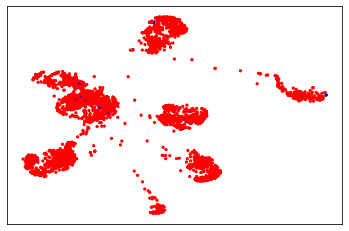

Training complete in 1m 42s


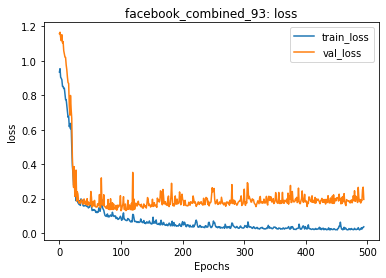

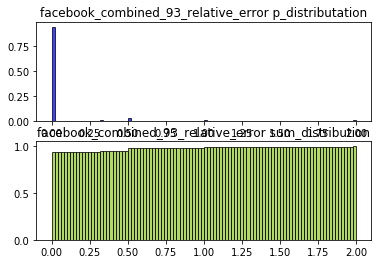

Best train loss: 0.018212 for # 93 beacons
Final train loss: 0.028513 for # 93 beacons
Final val loss: 0.195565 for # 93 beacons
add 1 new beacons
add beacons cost 0.58 s
x dataset shape: (1000, 190), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.9803361892700195
src:1208 des:700, true:1.0 est:1.9093371629714966
src:2836 des:2595, true:1.0 est:1.8464196920394897
src:669 des:1022, true:1.0 est:1.822964072227478
src:1188 des:1184, true:1.0 est:1.8006511926651
src:2111 des:2551, true:1.0 est:1.760679006576538
src:3399 des:2954, true:1.0 est:1.7508245706558228
src:1131 des:835, true:1.0 est:1.7429637908935547
src:877 des:853, true:1.0 est:1.7398874759674072
src:1394 des:1253, true:1.0 est:1.6820614337921143
src:2171 des:563, true:2.0 est:2.526371479034424
src:1413 des:57, true:3.0 est:3.5167462825775146
src:1563 des:374, true:2.0 est:2.460693359375
src:1794 des:4009, true:4.0 est:4.4556779861450195
src:1285 des:612, true:1.0 est:1.4283485412597656
src:3603 des:664, true:3.0 est:3.4281

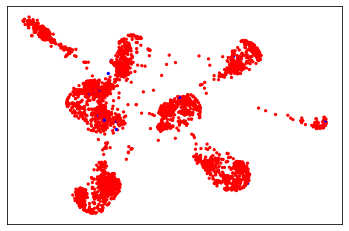

Training complete in 1m 46s


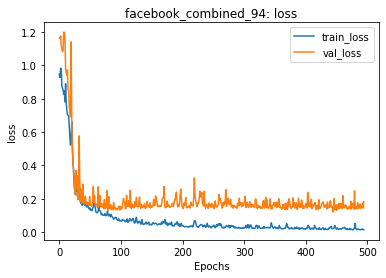

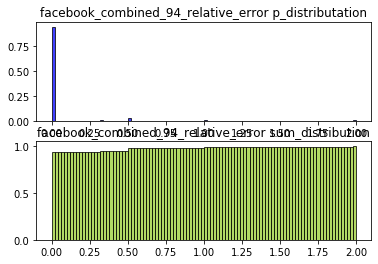

Best train loss: 0.013586 for # 94 beacons
Final train loss: 0.017483 for # 94 beacons
Final val loss: 0.182725 for # 94 beacons
add 2 new beacons
add beacons cost 0.60 s
x dataset shape: (1000, 194), y shape: (1000,)
src:2836 des:2595, true:1.0 est:2.0078787803649902
src:2111 des:2551, true:1.0 est:1.9337934255599976
src:3366 des:2986, true:1.0 est:1.8075051307678223
src:1208 des:700, true:1.0 est:1.7324390411376953
src:1188 des:1184, true:1.0 est:1.5915018320083618
src:913 des:1215, true:2.0 est:1.4445558786392212
src:877 des:853, true:1.0 est:1.5530043840408325
src:893 des:665, true:2.0 est:1.4598720073699951
src:3399 des:2954, true:1.0 est:1.475818395614624
src:1576 des:1778, true:3.0 est:2.577558994293213
src:1478 des:411, true:3.0 est:2.5904083251953125
src:1131 des:835, true:1.0 est:1.4050817489624023
src:1755 des:198, true:3.0 est:2.6066434383392334
src:896 des:3882, true:3.0 est:3.380577802658081
src:1394 des:1253, true:1.0 est:1.361099123954773
src:824 des:3176, true:3.0 est:

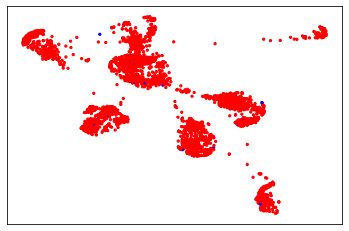

Training complete in 1m 46s


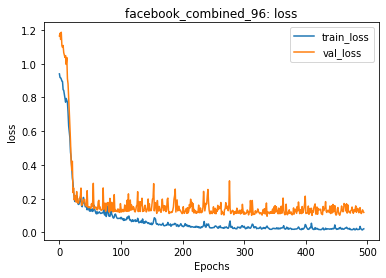

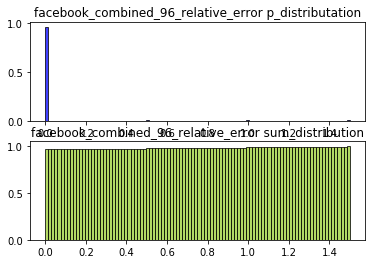

Best train loss: 0.014878 for # 96 beacons
Final train loss: 0.018356 for # 96 beacons
Final val loss: 0.118802 for # 96 beacons
add 1 new beacons
add beacons cost 0.65 s
x dataset shape: (1000, 196), y shape: (1000,)
src:3366 des:2986, true:1.0 est:1.9139419794082642
src:2836 des:2595, true:1.0 est:1.871570110321045
src:1208 des:700, true:1.0 est:1.8177728652954102
src:2111 des:2551, true:1.0 est:1.8039785623550415
src:1188 des:1184, true:1.0 est:1.7141826152801514
src:877 des:853, true:1.0 est:1.6486986875534058
src:1394 des:1253, true:1.0 est:1.5355936288833618
src:3399 des:2954, true:1.0 est:1.479231357574463
src:913 des:1215, true:2.0 est:1.5602768659591675
src:1478 des:411, true:3.0 est:2.654258966445923
src:669 des:1022, true:1.0 est:1.3200180530548096
src:3899 des:1191, true:4.0 est:3.6997976303100586
src:1413 des:57, true:3.0 est:3.295067071914673
src:1285 des:612, true:1.0 est:1.2913898229599
src:252 des:3317, true:4.0 est:3.7429797649383545
src:1131 des:835, true:1.0 est:1.2

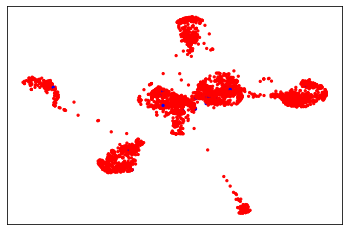

Training complete in 1m 45s


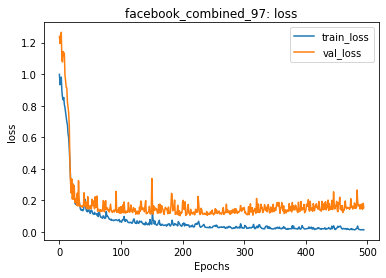

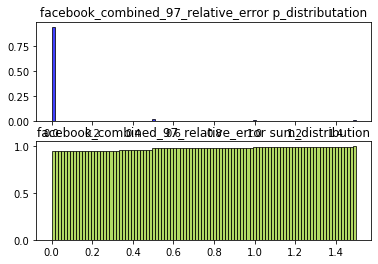

Best train loss: 0.012012 for # 97 beacons
Final train loss: 0.011482 for # 97 beacons
Final val loss: 0.152301 for # 97 beacons
add 2 new beacons
add beacons cost 0.50 s
x dataset shape: (1000, 200), y shape: (1000,)
src:3366 des:2986, true:1.0 est:2.023143768310547
src:1208 des:700, true:1.0 est:1.8692102432250977
src:669 des:1022, true:1.0 est:1.7986222505569458
src:2836 des:2595, true:1.0 est:1.7861040830612183
src:1188 des:1184, true:1.0 est:1.7637728452682495
src:2111 des:2551, true:1.0 est:1.743790626525879
src:1394 des:1253, true:1.0 est:1.7427690029144287
src:3399 des:2954, true:1.0 est:1.7408559322357178
src:877 des:853, true:1.0 est:1.661917805671692
src:1413 des:57, true:3.0 est:3.646036386489868
src:134 des:1415, true:3.0 est:3.543839454650879
src:2171 des:563, true:2.0 est:2.5146074295043945
src:1794 des:4009, true:4.0 est:4.465521335601807
src:290 des:1436, true:3.0 est:3.4579176902770996
src:226 des:102, true:2.0 est:2.455174684524536
src:14 des:77, true:2.0 est:2.45517

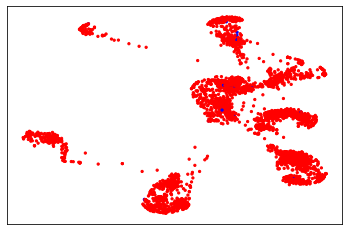

Training complete in 1m 46s


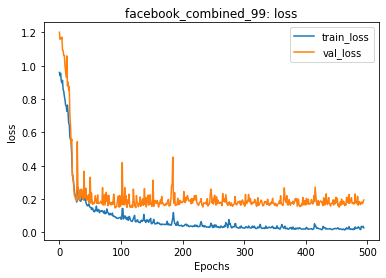

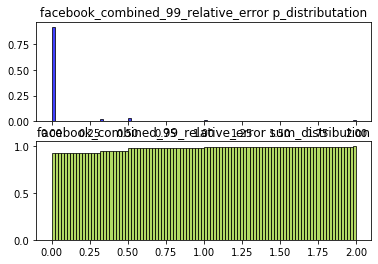

Best train loss: 0.014928 for # 99 beacons
Final train loss: 0.018498 for # 99 beacons
Final val loss: 0.194306 for # 99 beacons
add 1 new beacons
add beacons cost 0.66 s
x dataset shape: (1000, 202), y shape: (1000,)
src:2836 des:2595, true:1.0 est:2.0796284675598145
src:3366 des:2986, true:1.0 est:1.9354194402694702
src:1188 des:1184, true:1.0 est:1.9306087493896484
src:2111 des:2551, true:1.0 est:1.9133548736572266
src:1208 des:700, true:1.0 est:1.8391907215118408
src:1131 des:835, true:1.0 est:1.7145496606826782
src:3399 des:2954, true:1.0 est:1.7136844396591187
src:669 des:1022, true:1.0 est:1.6850135326385498
src:1394 des:1253, true:1.0 est:1.671238899230957
src:877 des:853, true:1.0 est:1.6526710987091064
src:1413 des:57, true:3.0 est:3.5447580814361572
src:1794 des:4009, true:4.0 est:4.539191246032715
src:1478 des:411, true:3.0 est:2.4776828289031982
src:3603 des:664, true:3.0 est:3.484022378921509
src:896 des:3882, true:3.0 est:3.473175048828125
src:1285 des:612, true:1.0 est:

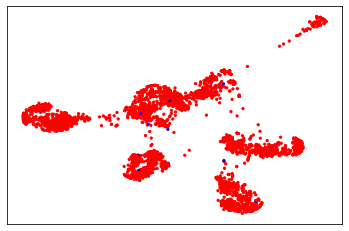

Training complete in 1m 48s


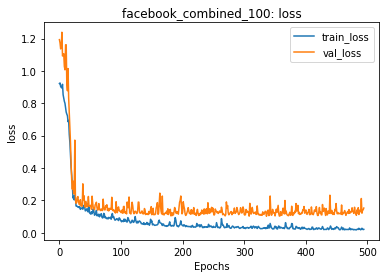

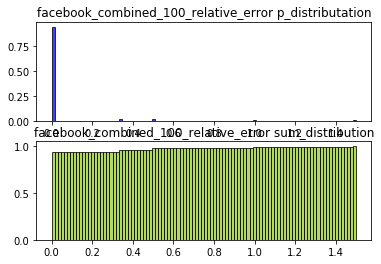

Best train loss: 0.017000 for # 100 beacons
Final train loss: 0.029263 for # 100 beacons
Final val loss: 0.152094 for # 100 beacons
add 1 new beacons
add beacons cost 0.56 s


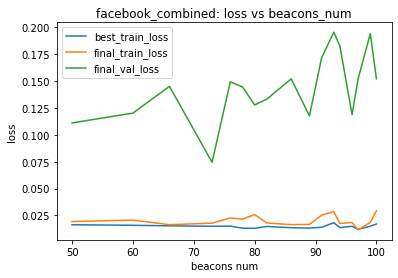

In [8]:
graph_path = "dataset/graph/facebook_combined.txt"
print("begin to train")
start = time.time()
tool = ReDistanceTool(graph_path = graph_path, graph_name = "facebook_combined", graph_type = 0)
print("prepare cost %.2f s" % (time.time() - start))
tool.train()